# Online Gradient Descent Based Portfolio Optimizer


This notebook extends upon Week 9's notebook by incorporating some ideas we talked about during the latest check in, such as running gradient descent over hyperparameters.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import numpy as np
import seaborn as sns

In [2]:
# Define the Magnificent 7 tickers
tickers = [
    # Technology & AI
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "AVGO", "ORCL", "IBM", "CSCO",

    # Financials & Banking
    "JPM", "V", "MA", "GS", "MS", "BAC", "C", "AXP", "SCHW",

    # Healthcare & Pharma
    "UNH", "JNJ", "LLY", "PFE", "MRNA", "BMY", "GILD", "CVS", "VRTX", "ISRG",

    # Consumer Goods & Retail
    "WMT", "NKE", "PG", "TGT", "COST", "KO", "PEP", "MCD", "SBUX", "YUM",

    # Energy & Utilities
    "XOM", "CVX", "NEE", "DUK", "SO", "D", "ENB", "SLB", "EOG", "PSX",

    # Industrials & Defense
    "DE", "LMT", "RTX", "BA", "CAT", "GE", "HON", "UPS", "EMR", "NOC",

    # Real Estate & Infrastructure
    "PLD", "AMT", "EQIX", "O", "SPG", "VICI", "DLR", "WY", "EQR", "PSA",

    # Transportation & Automotive
    "TSLA", "FDX", "UPS", "GM", "F", "RIVN", "NIO", "CSX", "UNP", "DAL",

    # Semiconductors
    "TSM", "ASML", "AMD", "TXN", "INTC", "MU", "QCOM", "LRCX", "NXPI", "ADI",

    # Agriculture & Food
    "ADM", "BG", "CF", "TSN", "MOS", "FMC", "CAG", "SYY", "HRL", "MDLZ",

    # Entertainment & Media
    "NFLX", "DIS", "PARA", "WBD", "CMCSA", "SPOT", "LYV", "TTWO", "EA",

    # Meme Stocks
    "GME", "AMC"
]

# Fetch historical price data for 2022-2023 (training period)
train_start_date = "2022-01-01"
train_end_date = "2023-12-31"

# Fetch historical price data for 2024 (testing period)
test_start_date = "2024-01-01"
test_end_date = datetime.now().strftime("%Y-%m-%d")  # Today's date

print(f"Training period: {train_start_date} to {train_end_date}")
print(f"Testing period: {test_start_date} to {test_end_date}")


Training period: 2022-01-01 to 2023-12-31
Testing period: 2024-01-01 to 2025-04-17


In [3]:
# Download adjusted close prices for both periods
train_prices = yf.download(
    tickers[:2], 
    start=train_start_date, 
    end=train_end_date
)["Close"]

print(f"Training data shape: {train_prices.shape}")

[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['MSFT', 'AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Training data shape: (0, 2)


In [13]:
train_prices = yf.download(
    ['AAPL'], 
    start="2022-01-01", 
    end="2023-01-01"
)["Close"]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


In [14]:
train_prices = yf.download(
    ['AAPL'], 
    start="2022-01-01", 
    end="2023-01-01"
)["Close"]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


## CRSP

In [3]:
import wrds
conn = wrds.Connection()

Loading library list...
Done


In [8]:
def get_stock_data(ticker, start, end):
    permno = conn.raw_sql(
        f"""
        SELECT DISTINCT permno 
        FROM crsp.msenames
        WHERE ticker = '{ticker}'
    """
    ).iloc[0]['permno']

    stock_data = conn.raw_sql(
        f"""
        SELECT permno, date, prc, ret
        FROM crsp.dsf
        WHERE permno = {permno}
        AND date BETWEEN '{start}' AND '{end}'
    """,
        date_cols=['date']
    )
    stock_data['ticker'] = ticker
    return stock_data

get_stock_data('AAPL', '2007-01-01', '2023-01-01')


,permno,date,prc,ret,ticker
0,14593,2007-01-03,83.8,-0.012258,AAPL
1,14593,2007-01-04,85.66,0.022196,AAPL
2,14593,2007-01-05,85.05,-0.007121,AAPL
3,14593,2007-01-08,85.47,0.004938,AAPL
4,14593,2007-01-09,92.57,0.08307,AAPL
...,...,...,...,...,...
4023,14593,2022-12-23,131.86,-0.002798,AAPL
4024,14593,2022-12-27,130.03,-0.013878,AAPL
4025,14593,2022-12-28,126.04,-0.030685,AAPL
4026,14593,2022-12-29,129.61,0.028324,AAPL


In [9]:
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "AVGO", "ORCL", "IBM", "CSCO",
    "JPM", "V", "MA", "GS", "MS", "BAC", "C", "AXP", "SCHW",
    "UNH", "JNJ", "LLY", "PFE", "MRNA", "BMY", "GILD", "CVS", "VRTX", "ISRG",
    "WMT", "NKE", "PG", "TGT", "COST", "KO", "PEP", "MCD", "SBUX", "YUM",
    "XOM", "CVX", "NEE", "DUK", "SO", "D", "ENB", "SLB", "EOG", "PSX",
    "DE", "LMT", "RTX", "BA", "CAT", "GE", "HON", "UPS", "EMR", "NOC",
    "PLD", "AMT", "EQIX", "O", "SPG", "VICI", "DLR", "WY", "EQR", "PSA",
    "TSLA", "FDX", "UPS", "GM", "F", "RIVN", "NIO", "CSX", "UNP", "DAL",
    "TSM", "ASML", "AMD", "TXN", "INTC", "MU", "QCOM", "LRCX", "NXPI", "ADI",
    "ADM", "BG", "CF", "TSN", "MOS", "FMC", "CAG", "SYY", "HRL", "MDLZ",
    "NFLX", "DIS", "PARA", "WBD", "CMCSA", "SPOT", "LYV", "TTWO", "EA",
    "GME", "AMC"
]

start = "2007-01-01"
end = "2023-01-01"
stock_data = pd.DataFrame()
for i, ticker in enumerate(tickers):
    data = get_stock_data(ticker, start, end)
    stock_data = pd.concat([stock_data, data], ignore_index=True)
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data = stock_data.set_index('date')
stock_data

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_86948/3528983945.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_data = pd.concat([stock_data, data], ignore_index=True)
/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_86948/3528983945.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_data = pd.concat([stock_data, data], ignore_index=True)
/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_86948/3528983945.py:21: FutureWarning: The behavior of Data

,permno,prc,ret,ticker
date,,,,
2007-01-03,14593,83.8,-0.012258,AAPL
2007-01-04,14593,85.66,0.022196,AAPL
2007-01-05,14593,85.05,-0.007121,AAPL
2007-01-08,14593,85.47,0.004938,AAPL
2007-01-09,14593,92.57,0.08307,AAPL
...,...,...,...,...
2007-02-01,90379,53.77,0.005799,GME
2007-02-02,90379,53.75,-0.000372,GME
2007-02-05,90379,52.98,-0.014326,GME


## EDA

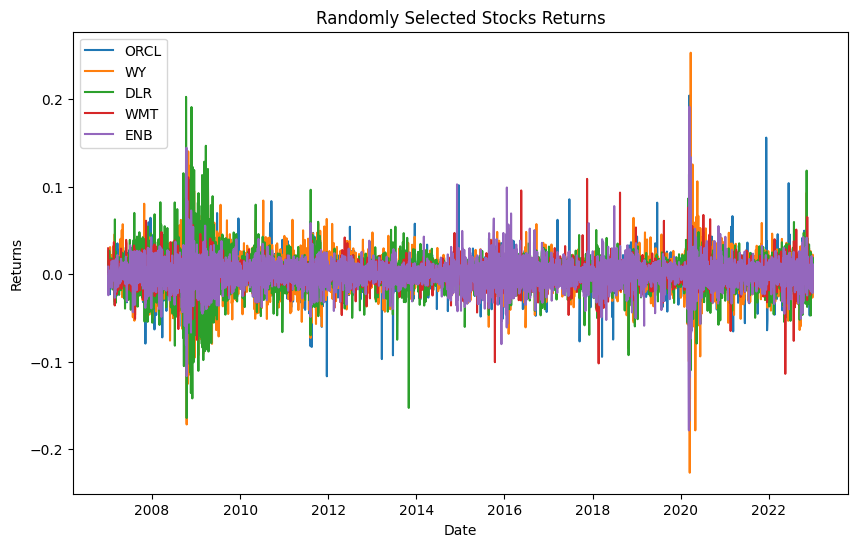

In [10]:
rand_choice = np.random.choice(tickers, size=5, replace=False)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
for ticker in rand_choice:
    data = stock_data[stock_data['ticker'] == ticker]
    ax.plot(data.index, data['ret'], label=ticker)

ax.set_title('Randomly Selected Stocks Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.legend()
plt.show()

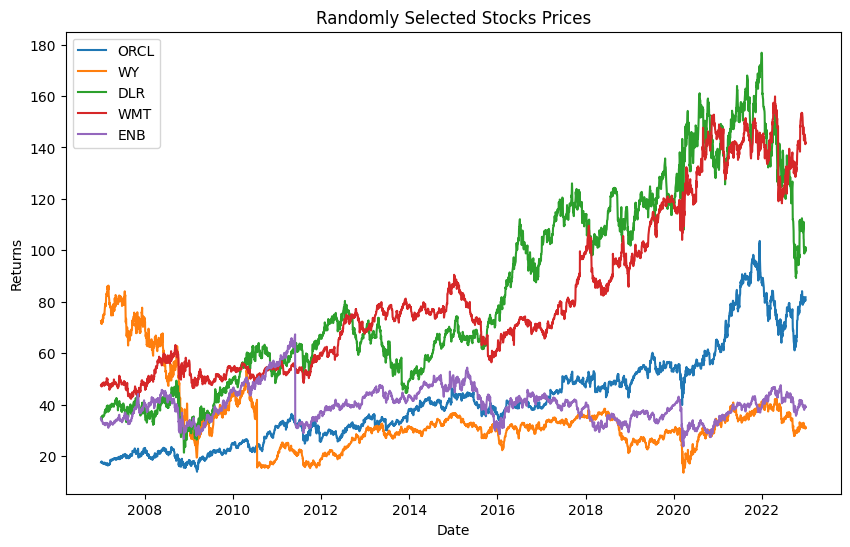

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
for ticker in rand_choice:
    data = stock_data[stock_data['ticker'] == ticker]
    ax.plot(data.index, data['prc'], label=ticker)

ax.set_title('Randomly Selected Stocks Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.legend()
plt.show()

We backtest an equal-weighted portfolio of 10 randomly chosen stocks at the start of 2007, for fun.

In [12]:
stock_data

,permno,prc,ret,ticker
date,,,,
2007-01-03,14593,83.8,-0.012258,AAPL
2007-01-04,14593,85.66,0.022196,AAPL
2007-01-05,14593,85.05,-0.007121,AAPL
2007-01-08,14593,85.47,0.004938,AAPL
2007-01-09,14593,92.57,0.08307,AAPL
...,...,...,...,...
2007-02-01,90379,53.77,0.005799,GME
2007-02-02,90379,53.75,-0.000372,GME
2007-02-05,90379,52.98,-0.014326,GME


In [13]:
returns = stock_data.pivot_table(
    index = ['date'],
    columns = ['ticker'],
    values = ['ret'],
    fill_value = 0
)
returns

ret                                                    \
ticker          AAPL       ADI       ADM       AMD       AMT      AMZN   
date                                                                     
2007-01-03 -0.012258 -0.000913  0.003129 -0.040786  0.019313  -0.01926   
2007-01-04  0.022196  0.017357 -0.005615  0.013832 -0.003947  0.005168   
2007-01-05 -0.007121 -0.011374 -0.001568 -0.004043 -0.008719 -0.013625   
2007-01-08  0.004938  0.007872  0.005027 -0.012177  0.028518 -0.022674   
2007-01-09   0.08307 -0.001502 -0.024383  0.009245  0.014512  0.007467   
...              ...       ...       ...       ...       ...       ...   
2022-12-23 -0.002798   0.00055  0.012087  0.010335  0.008784  0.017425   
2022-12-27 -0.013878  -0.01001  0.013634 -0.019374  0.000047 -0.025924   
2022-12-28 -0.030685 -0.011837 -0.023877 -0.011064 -0.003793 -0.014692   
2022-12-29  0.028324  0.023085 -0.005341   0.03596  0.026844  0.028844   
2022-12-30  0.002469  0.000305   -0.0029 -0.000771 -0.017985 -0.002138   

                                                    ...                      \
ticker          ASML       AXP        BA       BAC  ...       TXN       UNH   
date                                                ...                       
2007-01-03 -0.010556 -0.002637  0.003715 -0.001124  ... -0.008333 -0.021589   
2007-01-04  0.011079  -0.00729  0.004037  0.006375  ...  0.018908  0.006468   
2007-01-05  0.004464 -0.013184 -0.004244 -0.008012  ... -0.011684 -0.006804   
2007-01-08  0.011313  0.009471 -0.002356  0.003944  ...  0.004868  0.014653   
2007-01-09 -0.010787 -0.006366 -0.010569  0.000935  ... -0.002076 -0.012003   
...              ...       ...       ...       ...  ...       ...       ...   
2022-12-23 -0.008238  0.011768  0.004303   0.00247  ... -0.001943  0.008006   
2022-12-27 -0.025736 -0.004285  0.001798  0.001848  ...  -0.00365   0.00128   
2022-12-28 -0.010313 -0.016258 -0.005385  0.007378  ... -0.015814 -0.006654   
2022-12-29    0.0373  0.022985  0.002813  0.011291  ...  0.023761  0.002706   
2022-12-30 -0.009194  0.002919  0.008364 -0.000604  ...  0.001212  0.000566   

                                                                        \
ticker           UNP      VICI      VRTX       WBD       WMT        WY   
date                                                                     
2007-01-03  0.004999       0.0 -0.013896 -0.012923  0.029667  0.026185   
2007-01-04 -0.007353       0.0  0.002439 -0.019638  0.004837 -0.010069   
2007-01-05 -0.012418       0.0 -0.031901 -0.045652 -0.008162 -0.003205   
2007-01-08  0.001544       0.0 -0.063111  0.043768  -0.00823  0.008806   
2007-01-09  0.000551       0.0  0.009538 -0.045986  0.008298 -0.005127   
...              ...       ...       ...       ...       ...       ...   
2022-12-23  0.005991  0.014281 -0.014392       0.0  0.002021  0.014171   
2022-12-27  0.001953  0.001531 -0.008181       0.0  0.000278 -0.000635   
2022-12-28 -0.016404 -0.016198 -0.005429       0.0 -0.017523 -0.026692   
2022-12-29   0.01136  0.006834  0.011618       0.0  0.006087  0.022527   
2022-12-30 -0.010276 -0.000308 -0.001038       0.0 -0.002533 -0.010217   

                                
ticker           XOM       YUM  
date                            
2007-01-03 -0.032885   0.00102  
2007-01-04 -0.018756 -0.002718  
2007-01-05  0.007151 -0.008688  
2007-01-08 -0.008056 -0.002406  
2007-01-09 -0.007708   0.00379  
...              ...       ...  
2022-12-23  0.026445  0.000621  
2022-12-27  0.013894  0.007758  
2022-12-28 -0.016426 -0.004542  
2022-12-29  0.007566  0.005259  
2022-12-30  0.010073 -0.014694  

[4028 rows x 92 columns]

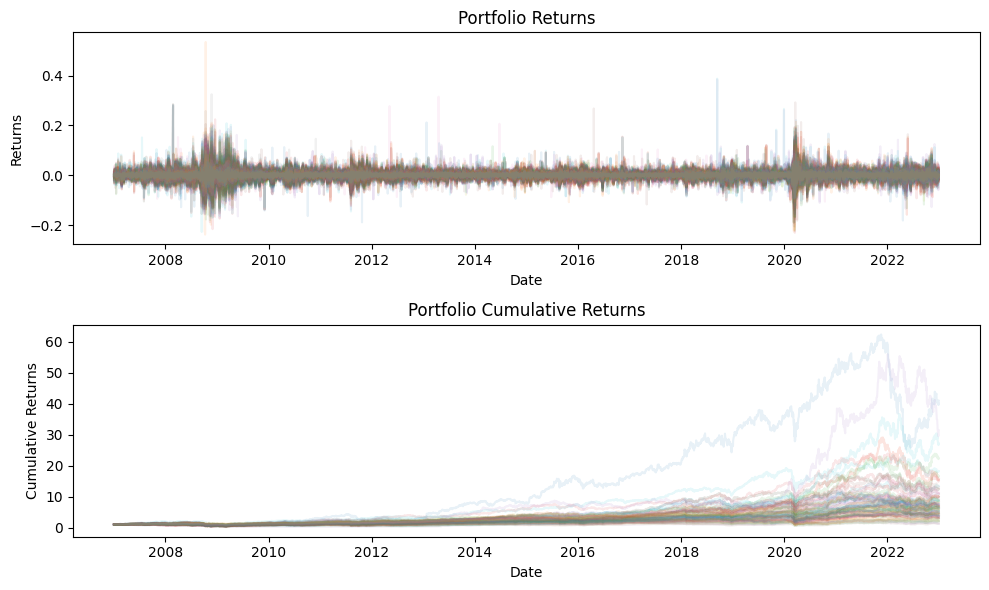

In [14]:
fig, axes = plt.subplots(2, 1, figsize = (10, 6))
n_stocks = 2
n_trials = 100


for _ in range(n_trials):
    p1_returns =[]

    rand_choice = (
        np.random.randint(0, returns.shape[1], size=n_stocks)
    )

    weights = np.zeros(returns.shape[1])
    weights[rand_choice] = 1 / n_stocks

    for date in returns.index:
        daily_returns = returns.loc[date].T
        p1_returns.append(
            np.dot(weights, daily_returns.values)
        )
    p1_returns = np.array(p1_returns)
    
    axes[0].plot(returns.index, p1_returns, alpha = 0.1,)
    axes[1].plot(returns.index, (p1_returns + 1).cumprod(), alpha = 0.1,)

axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()


Now we back test a portfolio where `n_stocks` are randomly selected each day. 

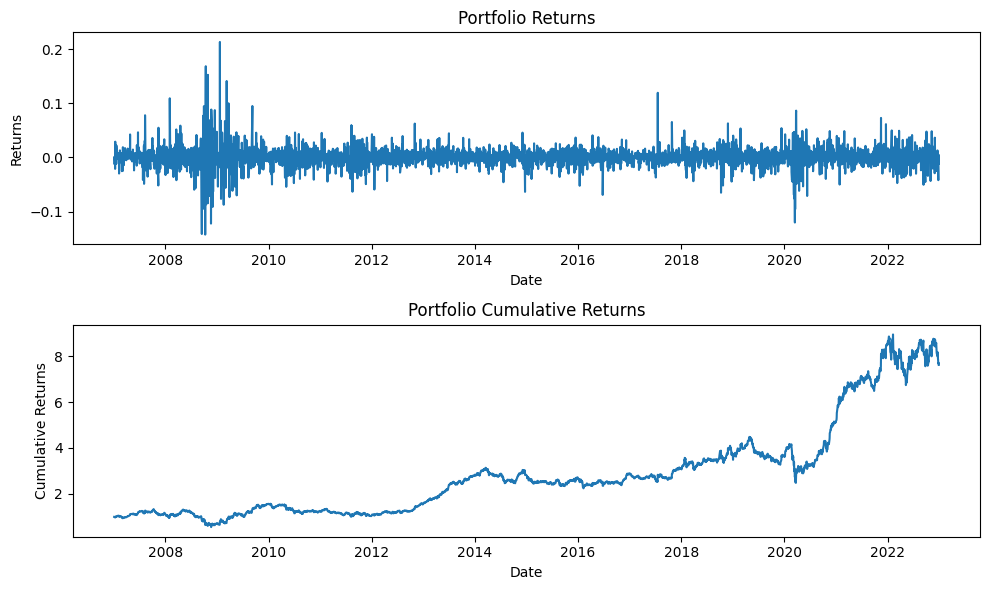

In [15]:
p2_returns = np.zeros(returns.shape[0])
n_stocks = 2

for i, date in enumerate(returns.index):
    daily_returns = returns.loc[date].T
    choice = np.random.randint(0, returns.shape[1], size=n_stocks)
    weights = np.zeros(returns.shape[1])
    weights[choice] = 1 / n_stocks

    p2_returns[i] = np.dot(weights, daily_returns.values)

fig, axes = plt.subplots(2, 1, figsize = (10, 6))
axes[0].plot(returns.index, p2_returns)
axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].plot(returns.index, (p2_returns + 1).cumprod())
axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()




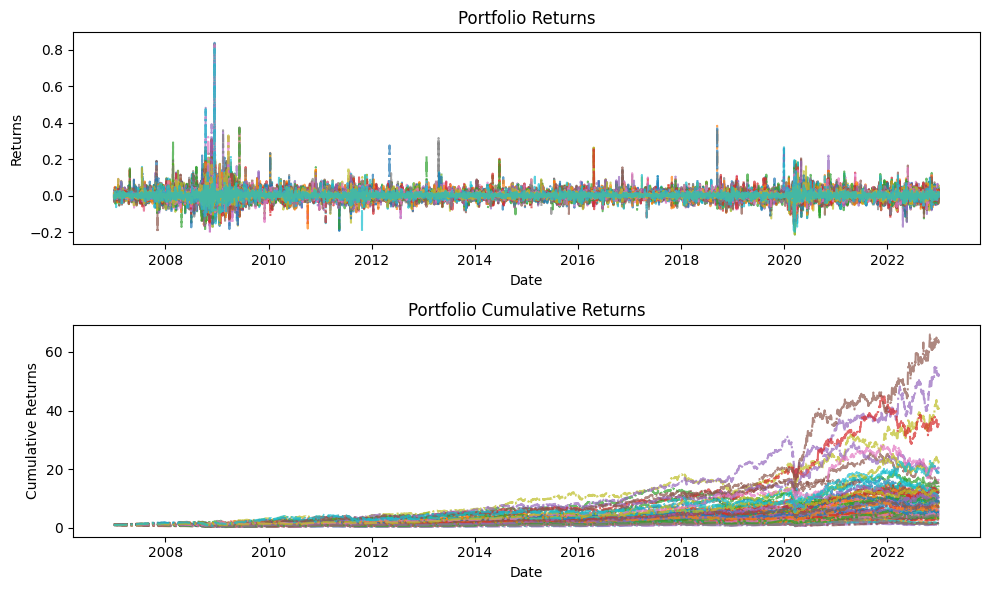

In [16]:
n_stocks = 2
n_trials = 100

fig, axes = plt.subplots(2, 1, figsize = (10, 6))
for _ in range(n_trials):
    p2_returns = np.zeros(returns.shape[0])

    for i, date in enumerate(returns.index):
        daily_returns = returns.loc[date].T
        choice = np.random.randint(0, returns.shape[1], size=n_stocks)
        weights = np.zeros(returns.shape[1])
        weights[choice] = 1 / n_stocks

        p2_returns[i] = np.dot(weights, daily_returns.values)

    axes[0].plot(returns.index, p2_returns, linestyle = '-.', alpha = .7)
    axes[1].plot(returns.index, (p2_returns + 1).cumprod(), linestyle = '-.', alpha = .7)


axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()




In [17]:
returns.shape[0]

4028

## Handwritten gradient descent

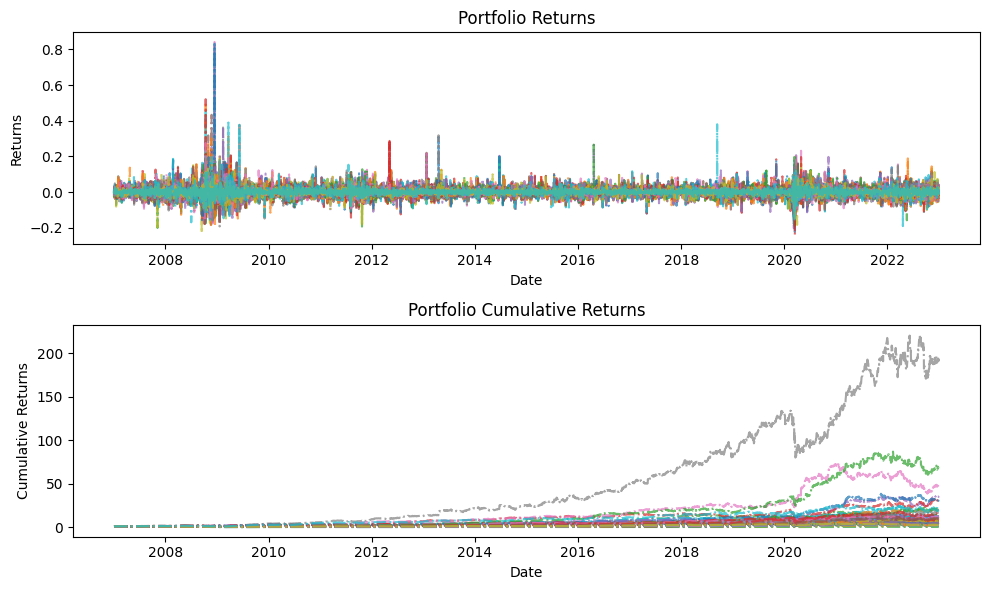

In [ ]:
n_stocks = 2
n_trials = 100

fig, axes = plt.subplots(2, 1, figsize = (10, 6))
for _ in range(n_trials):
    print(f"Running iteration {_}")
    p2_returns = torch.zeros(
        returns.shape[0], 
        dtype=torch.float32,
        requires_grad=False 
    )

    for i, date in enumerate(returns.index):
        daily_returns = returns.loc[date].T
        choice = torch.randint(
            low = 0,
            high = returns.shape[1], 
            size=(n_stocks,), 
            requires_grad=False
        )
        weights = torch.zeros(returns.shape[1], dtype=torch.float32, requires_grad=False)
        weights[choice] = 1 / n_stocks

        p2_returns[i] = torch.dot(
            weights,
            torch.tensor(daily_returns.values, dtype=torch.float32)
        )

    axes[0].plot(returns.index, p2_returns, linestyle = '-.', alpha = .7)
    axes[1].plot(returns.index, (p2_returns + 1).cumprod(dim = 0), linestyle = '-.', alpha = .7)


axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()




In [ ]:
def calculate_objective_func(returns: torch.tensor):
    return torch.mean(returns, dim=0)


window_size = 10

torch.manual_seed(42)
p2_returns = []

for i, date in enumerate(returns.index):
    daily_returns = returns.loc[date].T
    ret = torch.dot(
        weights,
        torch.tensor(daily_returns.values, dtype=torch.float32)
    )
    p2_returns.append(ret)
    if i >= window_size:
        past_returns = torch.as_tensor(
            p2_returns[max(0, i - window_size): i - 1],
            dtype=torch.float32,
        )
        expected_return = calculate_objective_func(past_returns)
        optimizer.zero_grad()
        expected_return.backward()
        optimizer.step()

p2_returns = torch.stack(p2_returns)    


fig, axes = plt.subplots(2, 1, figsize = (10, 6))
axes[0].plot(returns.index, p2_returns, linestyle = '-.', alpha = .7)
axes[1].plot(returns.index, (p2_returns + 1).cumprod(dim = 0), linestyle = '-.', alpha = .7)


axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

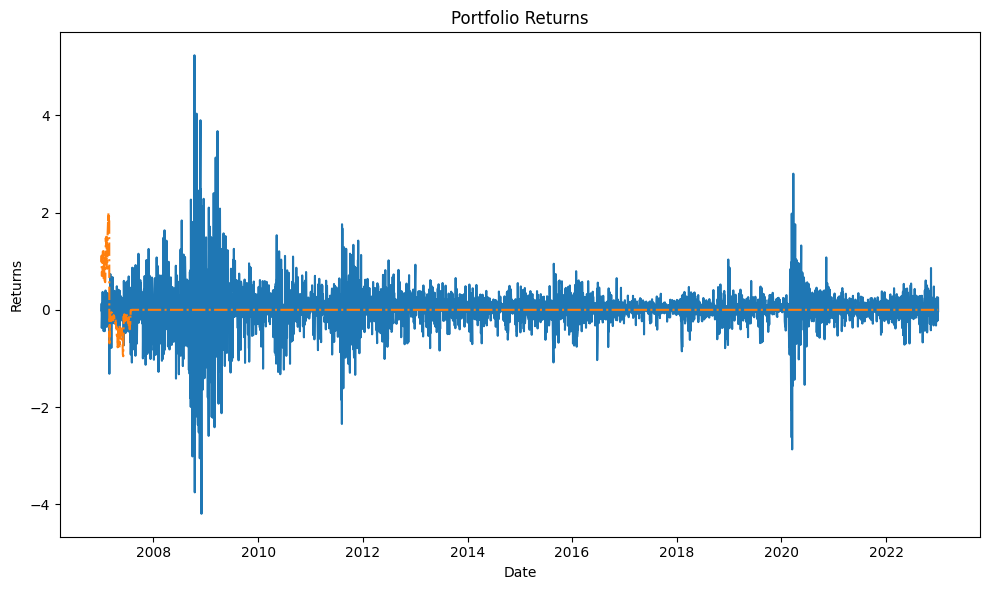

In [101]:
train_returns = []
plot_returns = []

weights = torch.rand(
    size = (returns.shape[1],), 
    requires_grad=True
)
optimizer = torch.optim.SGD([weights], lr=0.1)

for i, date in enumerate(returns.index):
    daily_returns = returns.loc[date].T
    daily_tensor = torch.tensor(daily_returns.values, dtype=torch.float32)

    ret = torch.dot(weights, daily_tensor)
    plot_returns.append(ret.detach())

    if i >= window_size:
        past_returns = []
        for j in range(max(0, i - window_size), i - 1):
            past_daily = returns.iloc[j].values
            past_ret = torch.dot(weights, torch.tensor(past_daily, dtype=torch.float32))
            past_returns.append(past_ret)

        past_returns = torch.stack(past_returns)
        expected_return = calculate_objective_func(past_returns)

        optimizer.zero_grad()
        expected_return.backward()
        optimizer.step()

plot_returns = np.asarray(plot_returns)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(
    returns.index, 
    plot_returns, 
    label = 'returns',
)
ax.plot(
    returns.index, 
    (plot_returns + 1).cumprod(), 
    linestyle = '-.', 
    label = 'cum returns'
)


ax.set_title('Portfolio Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Returns')

plt.tight_layout()
plt.show()

So this issue is because some of our `plot_returns` are close to -1. Some values in `(plot_returns + 1).cumprod()` get close to 0 and we end up with 0 cumulative return for all subsequent periods.

This issue is solved by adding softmax.

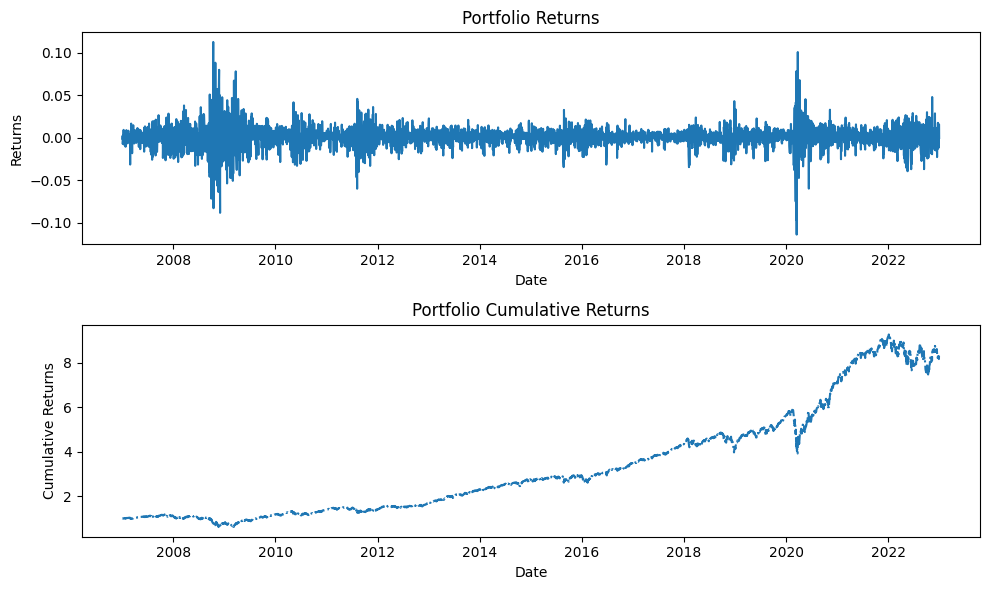

In [117]:
train_returns = []
plot_returns = []

weights = torch.rand(
    size = (returns.shape[1],), 
    requires_grad=True
)
optimizer = torch.optim.SGD([weights], lr=0.1)

weights_log = np.zeros((returns.shape[0], returns.shape[1]))

for i, date in enumerate(returns.index):
    normalized_weights = torch.nn.functional.softmax(weights, dim=0)
    daily_returns = returns.loc[date].T
    daily_tensor = torch.tensor(daily_returns.values, dtype=torch.float32)
    ret = torch.dot(normalized_weights, daily_tensor)
    plot_returns.append(ret.detach())

    if i >= window_size:
        past_returns = []
        for j in range(max(0, i - window_size), i - 1):
            past_daily = returns.iloc[j].values
            past_ret = torch.dot(normalized_weights, torch.tensor(past_daily, dtype=torch.float32))
            past_returns.append(past_ret)

        past_returns = torch.stack(past_returns)
        expected_return = calculate_objective_func(past_returns)

        optimizer.zero_grad()
        expected_return.backward()
        optimizer.step()
    
    weights_log[i] = normalized_weights.detach().numpy()

plot_returns = np.asarray(plot_returns)

fig, axes = plt.subplots(2, 1, figsize = (10, 6))
axes[0].plot(
    returns.index, 
    plot_returns, 
    label = 'returns',
)
axes[1].plot(
    returns.index, 
    (plot_returns + 1).cumprod(), 
    linestyle = '-.', 
    label = 'cum returns'
)


axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()

Now the gradient descent works. However, the next issue is that we are not making significant changes to our weights. 

We observe the weights evolution (vertical axis is 'time' or 'step'). The weights are staying relatively stable to the point that they get the same color label when plotting a heatmap.

[Text(0, 0.5, '0'),
 Text(0, 100.5, '100'),
 Text(0, 200.5, '200'),
 Text(0, 300.5, '300'),
 Text(0, 400.5, '400'),
 Text(0, 500.5, '500'),
 Text(0, 600.5, '600'),
 Text(0, 700.5, '700'),
 Text(0, 800.5, '800'),
 Text(0, 900.5, '900'),
 Text(0, 1000.5, '1000'),
 Text(0, 1100.5, '1100'),
 Text(0, 1200.5, '1200'),
 Text(0, 1300.5, '1300'),
 Text(0, 1400.5, '1400'),
 Text(0, 1500.5, '1500'),
 Text(0, 1600.5, '1600'),
 Text(0, 1700.5, '1700'),
 Text(0, 1800.5, '1800'),
 Text(0, 1900.5, '1900'),
 Text(0, 2000.5, '2000'),
 Text(0, 2100.5, '2100'),
 Text(0, 2200.5, '2200'),
 Text(0, 2300.5, '2300'),
 Text(0, 2400.5, '2400'),
 Text(0, 2500.5, '2500'),
 Text(0, 2600.5, '2600'),
 Text(0, 2700.5, '2700'),
 Text(0, 2800.5, '2800'),
 Text(0, 2900.5, '2900'),
 Text(0, 3000.5, '3000'),
 Text(0, 3100.5, '3100'),
 Text(0, 3200.5, '3200'),
 Text(0, 3300.5, '3300'),
 Text(0, 3400.5, '3400'),
 Text(0, 3500.5, '3500'),
 Text(0, 3600.5, '3600'),
 Text(0, 3700.5, '3700'),
 Text(0, 3800.5, '3800'),
 Text(0, 3

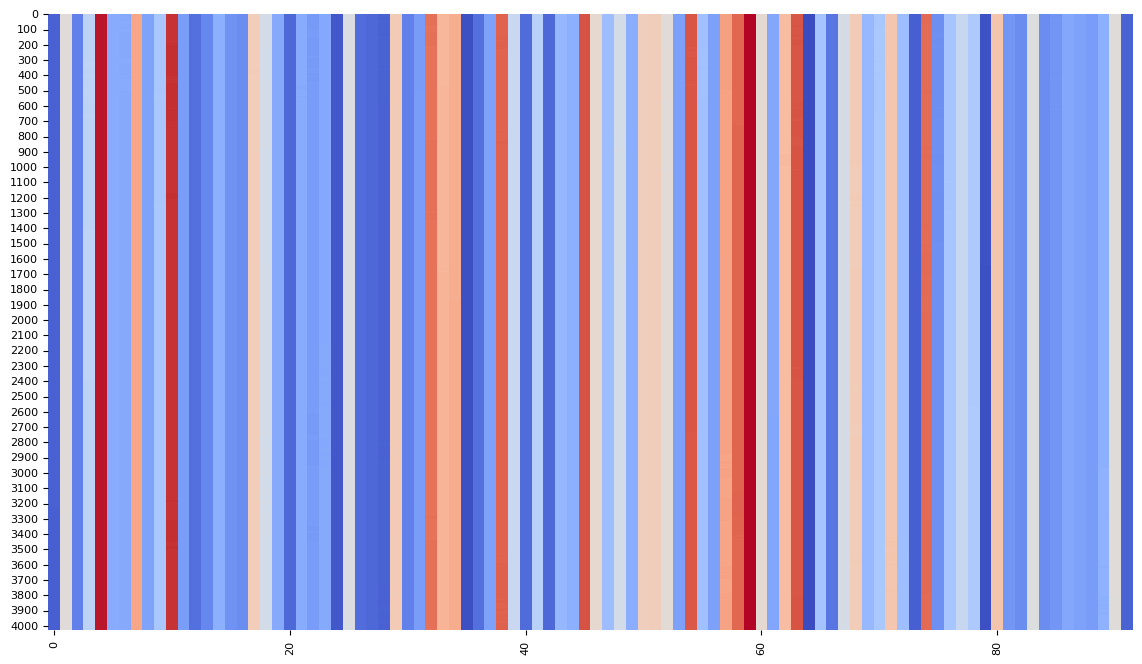

In [121]:
fig, ax = plt.subplots(1, 1, figsize = (14, 8))
sns.heatmap(
    weights_log, 
    cmap='coolwarm', 
    cbar=False,
    xticklabels=20, 
    yticklabels=100,
    ax = ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

In [129]:
weights_log[11] - weights_log[0]

array([-7.72997737e-08, -2.98023224e-08,  2.79396772e-08,  1.67638063e-07,
       -1.95577741e-07,  2.88709998e-08,  3.07336450e-08,  8.28877091e-08,
        1.95577741e-08,  1.21071935e-08, -2.08616257e-07, -1.02445483e-08,
        1.39698386e-09,  3.35276127e-08, -5.40167093e-08, -2.04890966e-08,
       -1.49011612e-08,  2.04890966e-08, -5.30853868e-08, -1.11758709e-08,
       -2.14204192e-08,  3.07336450e-08, -3.72529030e-09,  5.58793545e-09,
        2.32830644e-08,  2.42143869e-08, -4.79631126e-08, -2.79396772e-08,
       -2.79396772e-08, -3.53902578e-08,  8.38190317e-09, -1.21071935e-08,
       -3.35276127e-08,  1.21071935e-08, -1.05239451e-07, -4.28408384e-08,
       -3.95812094e-08,  9.31322575e-10,  2.98023224e-08, -4.09781933e-08,
       -5.63450158e-08,  5.02914190e-08,  1.39698386e-09,  9.31322575e-10,
        5.58793545e-09, -1.49011612e-08, -7.63684511e-08, -4.84287739e-08,
       -6.51925802e-08, -6.89178705e-08,  1.02445483e-08,  1.67638063e-08,
        1.51805580e-07, -

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_58265/2737164126.py:10: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axes[0].plot(
/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_58265/2737164126.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i + 1].legend()


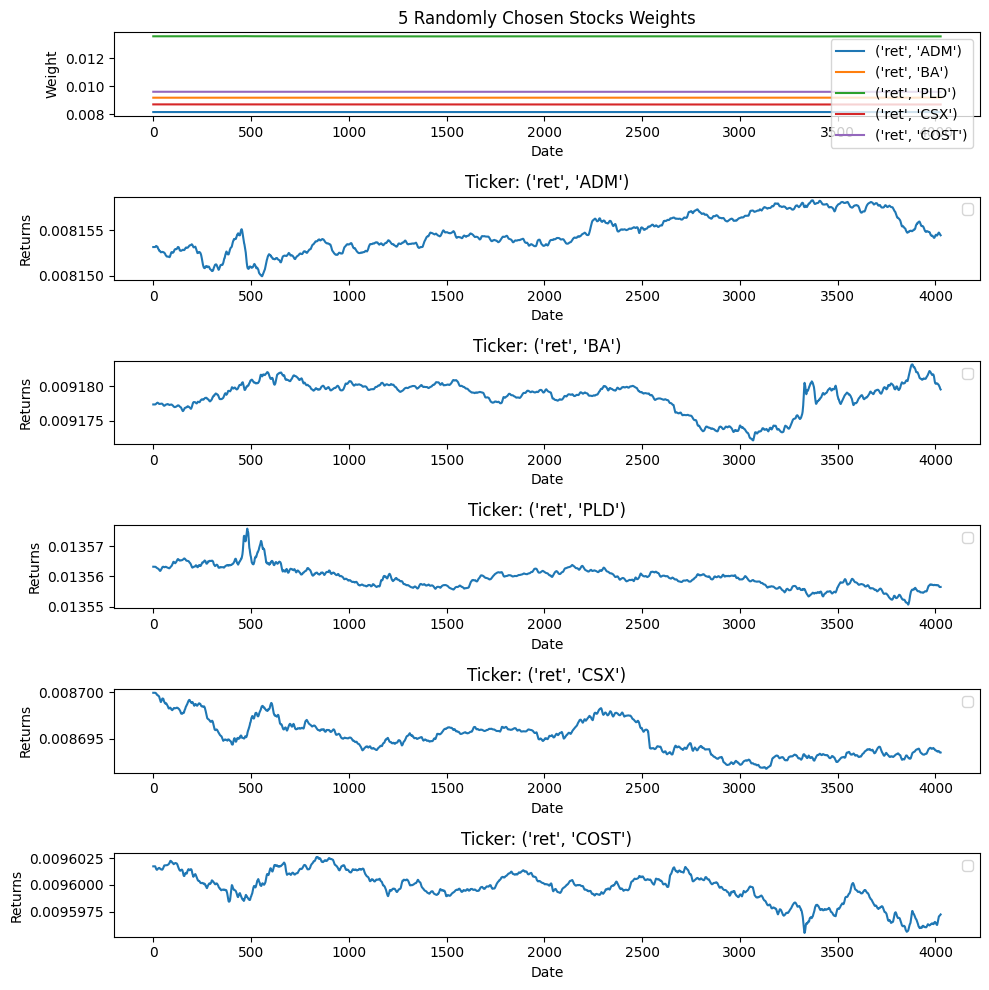

In [143]:
random_choice_tickers = np.random.randint(
    low = 0,
    high = returns.shape[1], 
    size=5
)

fig, axes = plt.subplots(6, 1, figsize = (10, 10))

for i, rng_ticker in enumerate(random_choice_tickers):
    axes[0].plot(
        weights_log[:, rng_ticker],
        label = returns.columns[rng_ticker],
    )
    axes[i + 1].plot(
        weights_log[:, rng_ticker], 
    )
    axes[i + 1].set_title(f"Ticker: {returns.columns[rng_ticker]}")
    axes[i + 1].set_xlabel('Date')
    axes[i + 1].set_ylabel('Returns')
    axes[i + 1].legend()

axes[0].set_title("5 Randomly Chosen Stocks Weights")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Weight')
axes[0].legend()
plt.tight_layout()
plt.show()

We are also not doing that much better than random guessing.

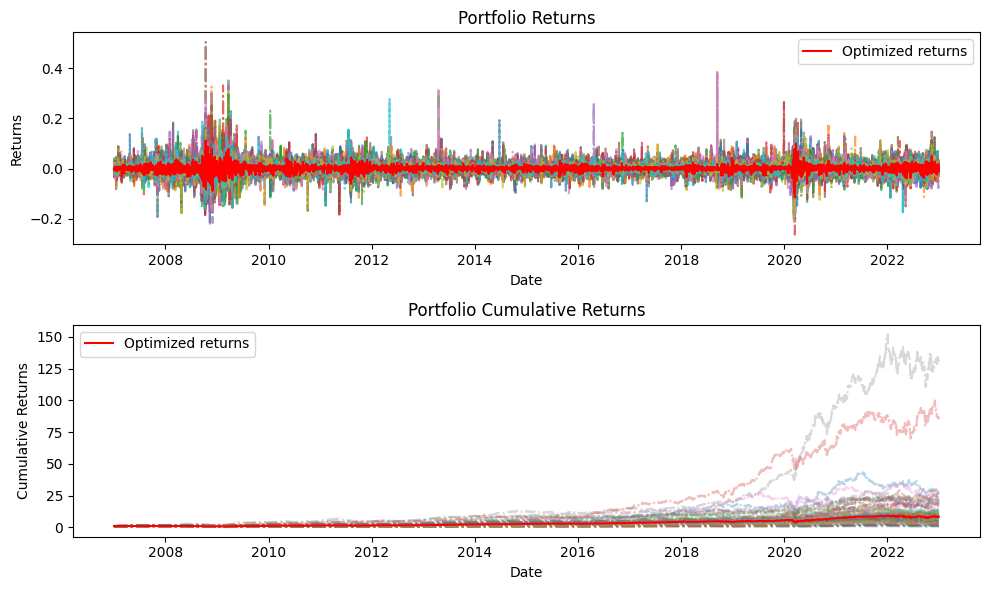

In [130]:
n_stocks = 2
n_trials = 100

fig, axes = plt.subplots(2, 1, figsize = (10, 6))
for _ in range(n_trials):
    p2_returns = np.zeros(returns.shape[0])

    for i, date in enumerate(returns.index):
        daily_returns = returns.loc[date].T
        choice = np.random.randint(0, returns.shape[1], size=n_stocks)
        weights = np.zeros(returns.shape[1])
        weights[choice] = 1 / n_stocks

        p2_returns[i] = np.dot(weights, daily_returns.values)

    axes[0].plot(returns.index, p2_returns, linestyle = '-.', alpha = .7)
    axes[1].plot(returns.index, (p2_returns + 1).cumprod(), linestyle = '-.', alpha = .3)


axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')


axes[0].plot(
    returns.index, 
    plot_returns, 
    label = 'Optimized returns',
    color = 'red'
)

axes[1].plot(
    returns.index, 
    (1 + plot_returns).cumprod(), 
    label = 'Optimized returns',
    color = 'red'
)

axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()




We try jacking up the learning rate. 

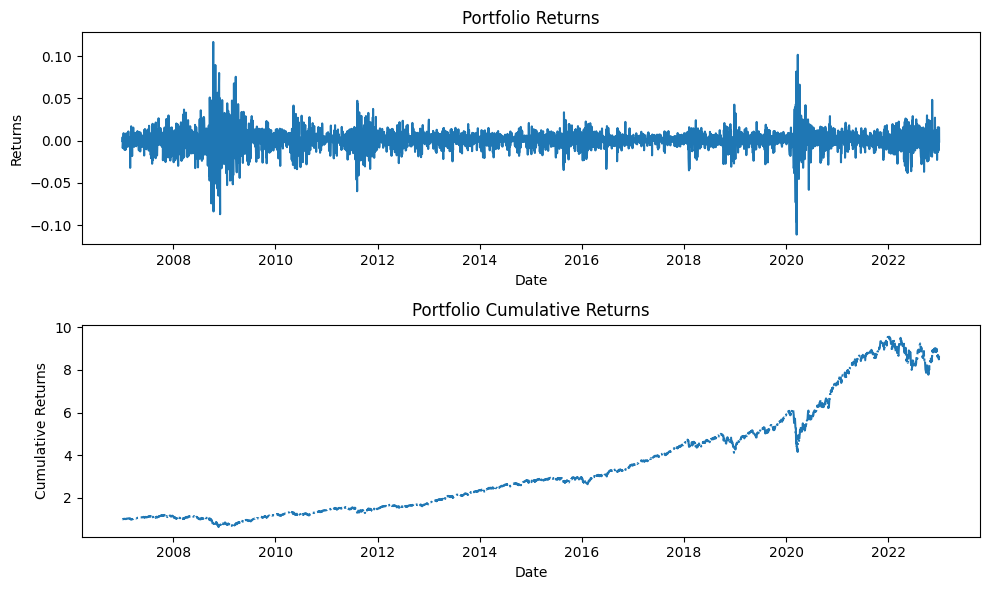

In [150]:
train_returns = []
plot_returns = []

weights = torch.rand(
    size = (returns.shape[1],), 
    requires_grad=True
)
optimizer = torch.optim.SGD([weights], lr=0.5)

weights_log = np.zeros((returns.shape[0], returns.shape[1]))

for i, date in enumerate(returns.index):
    normalized_weights = torch.nn.functional.softmax(weights, dim=0)
    daily_returns = returns.loc[date].T
    daily_tensor = torch.tensor(daily_returns.values, dtype=torch.float32)
    ret = torch.dot(normalized_weights, daily_tensor)
    plot_returns.append(ret.detach())

    if i >= window_size:
        past_returns = []
        for j in range(max(0, i - window_size), i - 1):
            past_daily = returns.iloc[j].values
            past_ret = torch.dot(normalized_weights, torch.tensor(past_daily, dtype=torch.float32))
            past_returns.append(past_ret)

        past_returns = torch.stack(past_returns)
        expected_return = calculate_objective_func(past_returns)

        optimizer.zero_grad()
        expected_return.backward()
        optimizer.step()
    
    weights_log[i] = normalized_weights.detach().numpy()

plot_returns = np.asarray(plot_returns)

fig, axes = plt.subplots(2, 1, figsize = (10, 6))
axes[0].plot(
    returns.index, 
    plot_returns, 
    label = 'returns',
)
axes[1].plot(
    returns.index, 
    (plot_returns + 1).cumprod(), 
    linestyle = '-.', 
    label = 'cum returns'
)


axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()

[Text(0, 0.5, '0'),
 Text(0, 100.5, '100'),
 Text(0, 200.5, '200'),
 Text(0, 300.5, '300'),
 Text(0, 400.5, '400'),
 Text(0, 500.5, '500'),
 Text(0, 600.5, '600'),
 Text(0, 700.5, '700'),
 Text(0, 800.5, '800'),
 Text(0, 900.5, '900'),
 Text(0, 1000.5, '1000'),
 Text(0, 1100.5, '1100'),
 Text(0, 1200.5, '1200'),
 Text(0, 1300.5, '1300'),
 Text(0, 1400.5, '1400'),
 Text(0, 1500.5, '1500'),
 Text(0, 1600.5, '1600'),
 Text(0, 1700.5, '1700'),
 Text(0, 1800.5, '1800'),
 Text(0, 1900.5, '1900'),
 Text(0, 2000.5, '2000'),
 Text(0, 2100.5, '2100'),
 Text(0, 2200.5, '2200'),
 Text(0, 2300.5, '2300'),
 Text(0, 2400.5, '2400'),
 Text(0, 2500.5, '2500'),
 Text(0, 2600.5, '2600'),
 Text(0, 2700.5, '2700'),
 Text(0, 2800.5, '2800'),
 Text(0, 2900.5, '2900'),
 Text(0, 3000.5, '3000'),
 Text(0, 3100.5, '3100'),
 Text(0, 3200.5, '3200'),
 Text(0, 3300.5, '3300'),
 Text(0, 3400.5, '3400'),
 Text(0, 3500.5, '3500'),
 Text(0, 3600.5, '3600'),
 Text(0, 3700.5, '3700'),
 Text(0, 3800.5, '3800'),
 Text(0, 3

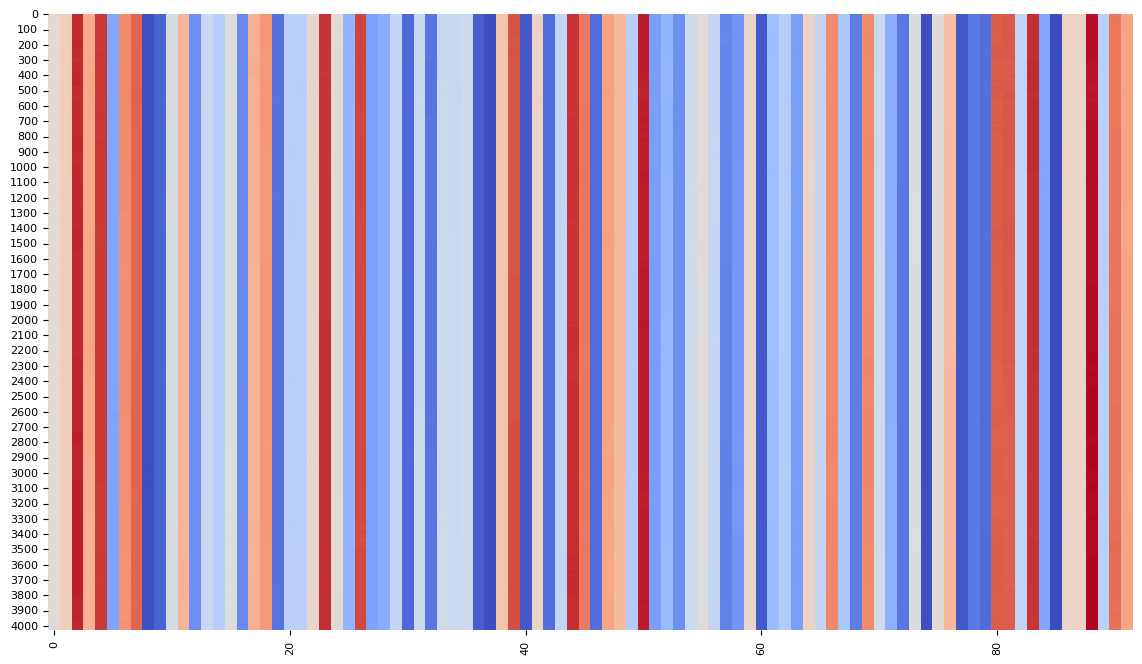

In [151]:
fig, ax = plt.subplots(1, 1, figsize = (14, 8))
sns.heatmap(
    weights_log, 
    cmap='coolwarm', 
    cbar=False,
    xticklabels=20, 
    yticklabels=100,
    ax = ax
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_58265/2737164126.py:10: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axes[0].plot(
/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_58265/2737164126.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i + 1].legend()


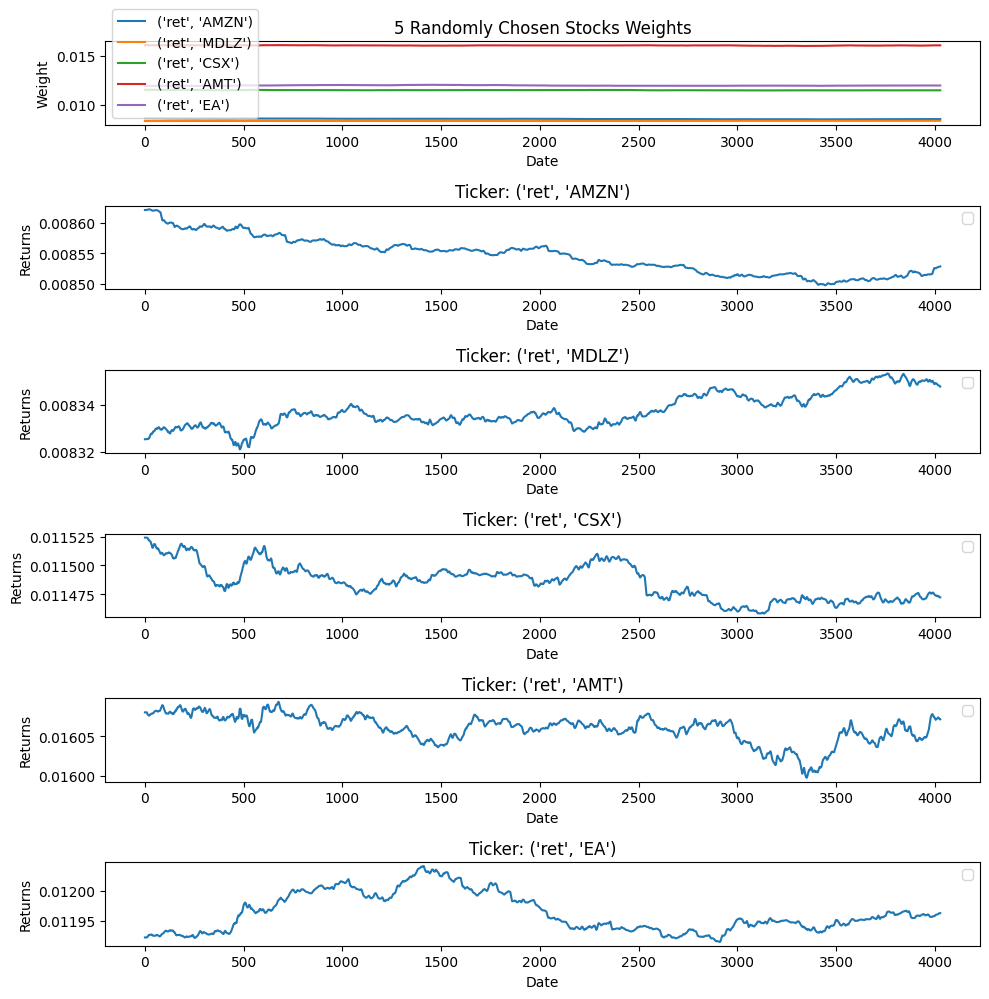

In [152]:
random_choice_tickers = np.random.randint(
    low = 0,
    high = returns.shape[1], 
    size=5
)

fig, axes = plt.subplots(6, 1, figsize = (10, 10))

for i, rng_ticker in enumerate(random_choice_tickers):
    axes[0].plot(
        weights_log[:, rng_ticker],
        label = returns.columns[rng_ticker],
    )
    axes[i + 1].plot(
        weights_log[:, rng_ticker], 
    )
    axes[i + 1].set_title(f"Ticker: {returns.columns[rng_ticker]}")
    axes[i + 1].set_xlabel('Date')
    axes[i + 1].set_ylabel('Returns')
    axes[i + 1].legend()

axes[0].set_title("5 Randomly Chosen Stocks Weights")
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Weight')
axes[0].legend()
plt.tight_layout()
plt.show()

We also try using a shorter window. Longer window smooths things over. Shorter window might result in sharper movements.

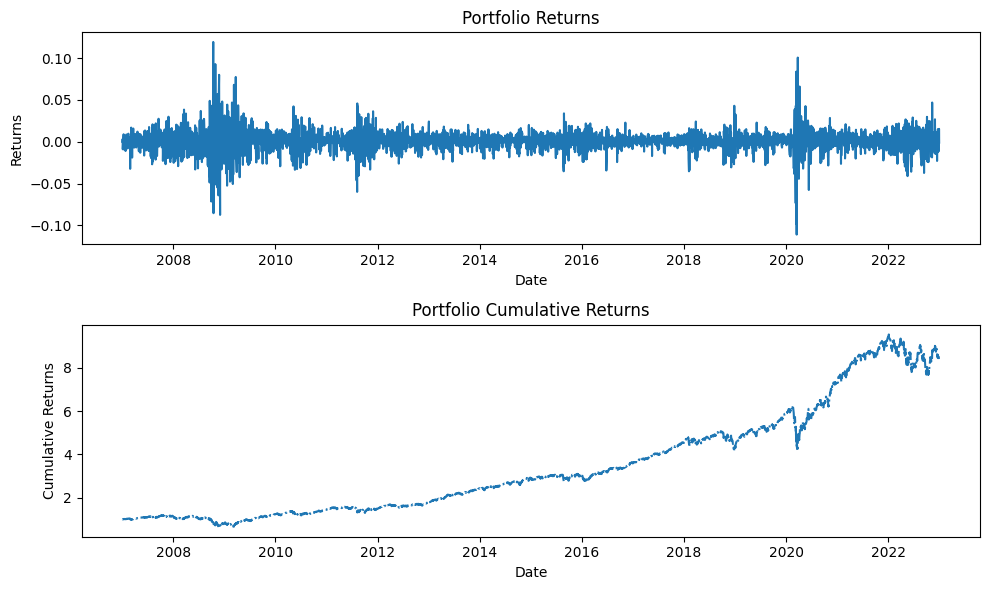

In [153]:
train_returns = []
plot_returns = []

window_size = 3

weights = torch.rand(
    size = (returns.shape[1],), 
    requires_grad=True
)
optimizer = torch.optim.SGD([weights], lr=0.5)
weights_log = np.zeros((returns.shape[0], returns.shape[1]))

for i, date in enumerate(returns.index):
    normalized_weights = torch.nn.functional.softmax(weights, dim=0)
    daily_returns = returns.loc[date].T
    daily_tensor = torch.tensor(daily_returns.values, dtype=torch.float32)
    ret = torch.dot(normalized_weights, daily_tensor)
    plot_returns.append(ret.detach())

    if i >= window_size:
        past_returns = []
        for j in range(max(0, i - window_size), i - 1):
            past_daily = returns.iloc[j].values
            past_ret = torch.dot(normalized_weights, torch.tensor(past_daily, dtype=torch.float32))
            past_returns.append(past_ret)

        past_returns = torch.stack(past_returns)
        expected_return = calculate_objective_func(past_returns)

        optimizer.zero_grad()
        expected_return.backward()
        optimizer.step()
    
    weights_log[i] = normalized_weights.detach().numpy()

plot_returns = np.asarray(plot_returns)

fig, axes = plt.subplots(2, 1, figsize = (10, 6))
axes[0].plot(
    returns.index, 
    plot_returns, 
    label = 'returns',
)
axes[1].plot(
    returns.index, 
    (plot_returns + 1).cumprod(), 
    linestyle = '-.', 
    label = 'cum returns'
)


axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_58265/1774930600.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


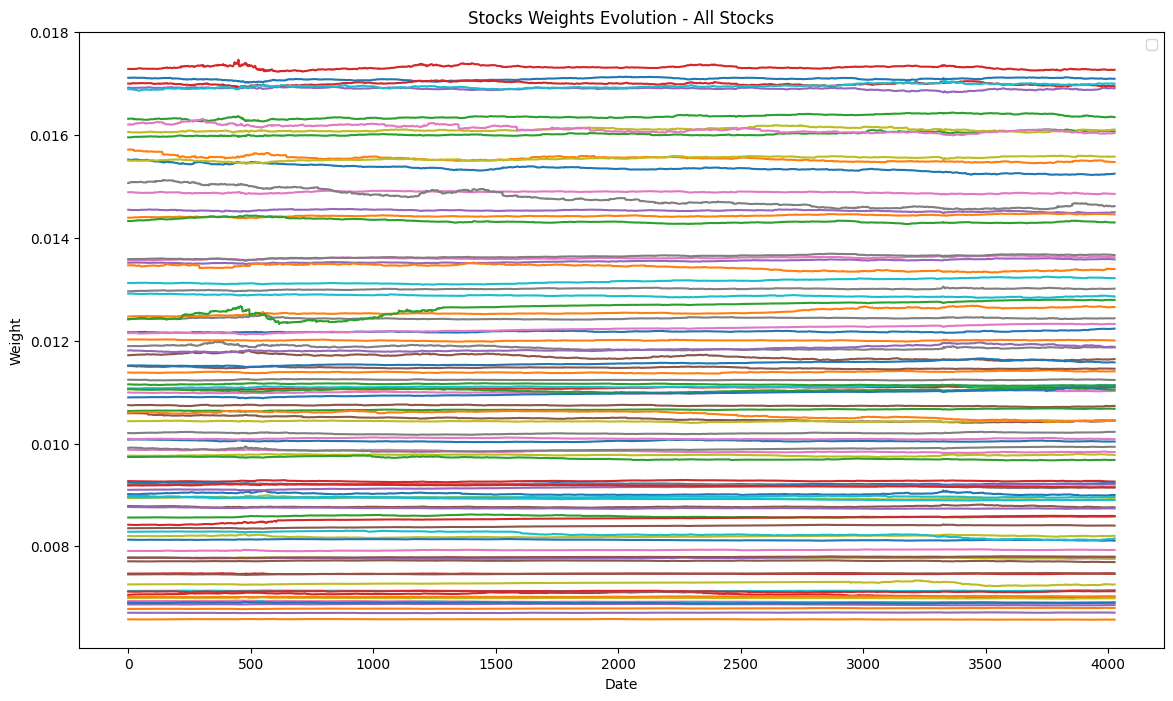

In [155]:
fig, ax = plt.subplots(1, 1, figsize = (14, 8))
for i in range(weights_log.shape[1]):
    ax.plot(weights_log[:, i])


ax.set_title("Stocks Weights Evolution - All Stocks")
ax.set_xlabel('Date')
ax.set_ylabel('Weight')
ax.legend()

We make things a little more exciting by incorporating Sharpe ratio.

To use the Sharpe Ratio, we need to pull the risk free rate data. Furthermore, it only makes sense if our model can also observe what the risk free rate was. 

In [18]:
stock_data

,permno,prc,ret,ticker
date,,,,
2007-01-03,14593,83.8,-0.012258,AAPL
2007-01-04,14593,85.66,0.022196,AAPL
2007-01-05,14593,85.05,-0.007121,AAPL
2007-01-08,14593,85.47,0.004938,AAPL
2007-01-09,14593,92.57,0.08307,AAPL
...,...,...,...,...
2007-02-01,90379,53.77,0.005799,GME
2007-02-02,90379,53.75,-0.000372,GME
2007-02-05,90379,52.98,-0.014326,GME


In [21]:
def get_risk_free_data(start, end):
    risk_free_data = conn.raw_sql(
        f"""
        SELECT date, rf
        FROM ff.factors_daily 
        WHERE date BETWEEN '{start}' AND '{end}'
    """,
        date_cols=['date']
    )
    risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])
    risk_free_data = risk_free_data.set_index('date')
    return risk_free_data

risk_free_data = get_risk_free_data("2007-01-01", "2024-12-31")

In [22]:
stock_data = stock_data.merge(
    risk_free_data, 
    left_index=True, 
    right_index=True, 
    how='left'
)

stock_data

,permno,prc,ret,ticker,mktrf,rf
date,,,,,,
2007-01-03,14593,83.8,-0.012258,AAPL,-0.0004,0.00022
2007-01-04,14593,85.66,0.022196,AAPL,0.0016,0.00022
2007-01-05,14593,85.05,-0.007121,AAPL,-0.0073,0.00022
2007-01-08,14593,85.47,0.004938,AAPL,0.0024,0.00022
2007-01-09,14593,92.57,0.08307,AAPL,0.0,0.00022
...,...,...,...,...,...,...
2007-02-01,90379,53.77,0.005799,GME,0.0059,0.0002
2007-02-02,90379,53.75,-0.000372,GME,0.0015,0.0002
2007-02-05,90379,52.98,-0.014326,GME,-0.0012,0.0002


In [ ]:
risk_free_data

In [27]:
returns = stock_data.pivot_table(
    index = ['date'],
    columns = ['ticker'],
    values = ['ret'],
    fill_value = 0
)['ret'].merge(
    risk_free_data, 
    left_index=True, 
    right_index=True, 
    how='left'
)
returns

,AAPL,ADI,ADM,AMD,AMT,AMZN,ASML,AXP,BA,BAC,...,UNH,UNP,VICI,VRTX,WBD,WMT,WY,XOM,YUM,rf
date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,-0.012258,-0.000913,0.003129,-0.040786,0.019313,-0.01926,-0.010556,-0.002637,0.003715,-0.001124,...,-0.021589,0.004999,0.0,-0.013896,-0.012923,0.029667,0.026185,-0.032885,0.00102,0.00022
2007-01-04,0.022196,0.017357,-0.005615,0.013832,-0.003947,0.005168,0.011079,-0.00729,0.004037,0.006375,...,0.006468,-0.007353,0.0,0.002439,-0.019638,0.004837,-0.010069,-0.018756,-0.002718,0.00022
2007-01-05,-0.007121,-0.011374,-0.001568,-0.004043,-0.008719,-0.013625,0.004464,-0.013184,-0.004244,-0.008012,...,-0.006804,-0.012418,0.0,-0.031901,-0.045652,-0.008162,-0.003205,0.007151,-0.008688,0.00022
2007-01-08,0.004938,0.007872,0.005027,-0.012177,0.028518,-0.022674,0.011313,0.009471,-0.002356,0.003944,...,0.014653,0.001544,0.0,-0.063111,0.043768,-0.00823,0.008806,-0.008056,-0.002406,0.00022
2007-01-09,0.08307,-0.001502,-0.024383,0.009245,0.014512,0.007467,-0.010787,-0.006366,-0.010569,0.000935,...,-0.012003,0.000551,0.0,0.009538,-0.045986,0.008298,-0.005127,-0.007708,0.00379,0.00022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.002798,0.00055,0.012087,0.010335,0.008784,0.017425,-0.008238,0.011768,0.004303,0.00247,...,0.008006,0.005991,0.014281,-0.014392,0.0,0.002021,0.014171,0.026445,0.000621,0.00016
2022-12-27,-0.013878,-0.01001,0.013634,-0.019374,0.000047,-0.025924,-0.025736,-0.004285,0.001798,0.001848,...,0.00128,0.001953,0.001531,-0.008181,0.0,0.000278,-0.000635,0.013894,0.007758,0.00016
2022-12-28,-0.030685,-0.011837,-0.023877,-0.011064,-0.003793,-0.014692,-0.010313,-0.016258,-0.005385,0.007378,...,-0.006654,-0.016404,-0.016198,-0.005429,0.0,-0.017523,-0.026692,-0.016426,-0.004542,0.00016


Theoretically modern portfolio theory / capital asset allocation is built upon the existence of a risk free asset.

However, for now we limit the ability to invest at the risk free rate.

We might relax this later on, and then compare the gradient-descent yielded optimal portfolio against that of a mean-variance optimized portfolio.

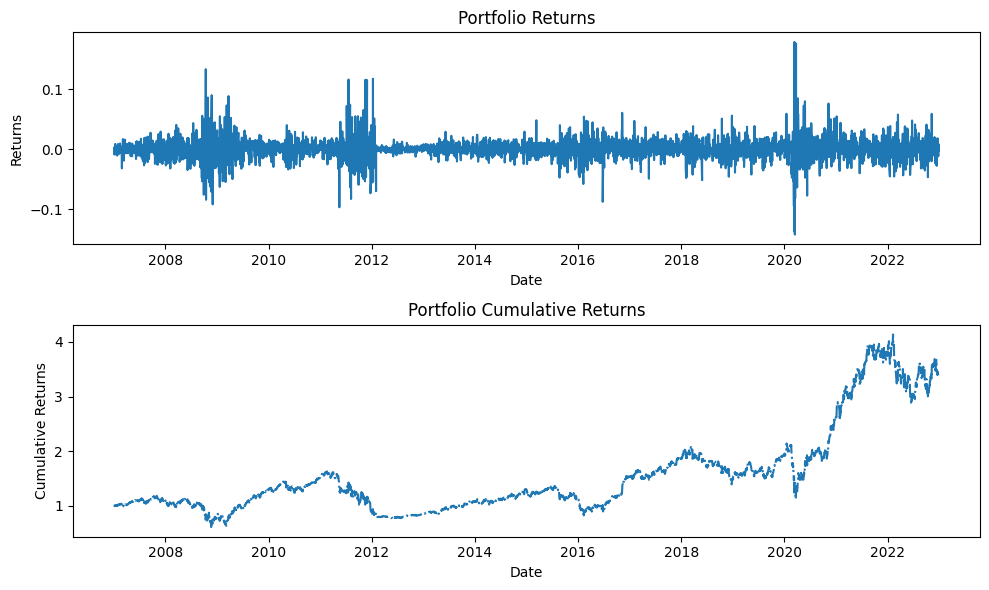

In [32]:
train_returns = []
plot_returns = []
plot_excess_returns = []
window_size = 10

def calculate_objective_func(
        returns: torch.tensor,
        risk_free_rate: torch.tensor = None
    ):
    if risk_free_rate is not None:
        excess_returns = returns - risk_free_rate
    else:
        excess_returns = returns
    sharpe = torch.mean(excess_returns, dim=0) / torch.std(excess_returns, dim=0)
    return sharpe

# returns.shape[1] - 1 because we don't allow investing in 
# risk free asset for the moment 

weights = torch.rand(
    size = (returns.shape[1] - 1,), 
    requires_grad=True
)
optimizer = torch.optim.SGD([weights], lr=0.5)
weights_log = np.zeros((returns.shape[0], returns.shape[1] - 1))

for i, date in enumerate(returns.index):
    normalized_weights = torch.nn.functional.softmax(weights, dim=0)
    daily_returns = returns.loc[date].T
    daily_tensor = torch.tensor(daily_returns.values, dtype=torch.float32)[:-1]

    ret = torch.dot(normalized_weights, daily_tensor)
    plot_returns.append(ret.detach())
    plot_excess_returns.append(
        ret.detach() - returns.iloc[i]['rf']
    )

    if i >= window_size:
        past_returns = []
        past_risk_free = []
        for j in range(max(0, i - window_size), i - 1):
            past_daily = returns.iloc[j].values
            past_ret = torch.dot(
                normalized_weights, 
                torch.tensor(past_daily, dtype=torch.float32)[:-1]
            )
            past_returns.append(past_ret)
            past_risk_free.append(past_daily[-1])

        past_returns = torch.stack(past_returns)
        past_risk_free = torch.as_tensor(past_risk_free)
        sharpe = calculate_objective_func(
            past_returns, 
            past_risk_free
        )

        optimizer.zero_grad()
        sharpe.backward()
        optimizer.step()
    
    weights_log[i] = normalized_weights.detach().numpy()

plot_returns = np.asarray(plot_returns)

fig, axes = plt.subplots(2, 1, figsize = (10, 6))
axes[0].plot(
    returns.index, 
    plot_returns, 
    label = 'returns',
)
axes[1].plot(
    returns.index, 
    (plot_returns + 1).cumprod(), 
    linestyle = '-.', 
    label = 'cum returns'
)

axes[0].set_title('Portfolio Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')

axes[1].set_title('Portfolio Cumulative Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Returns')

plt.tight_layout()
plt.show()

/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_86948/1774930600.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


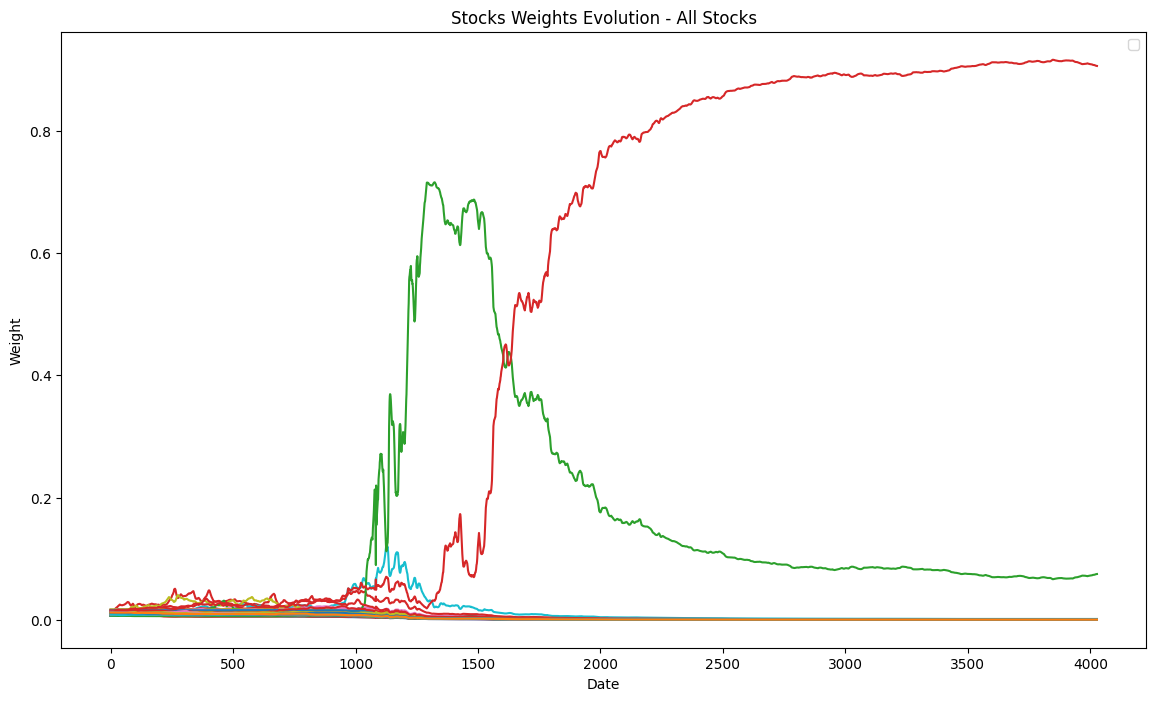

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (14, 8))
for i in range(weights_log.shape[1]):
    ax.plot(weights_log[:, i])

ax.set_title("Stocks Weights Evolution - All Stocks")
ax.set_xlabel('Date')
ax.set_ylabel('Weight')
ax.legend()

In [36]:
returns.columns[weights_log[-1].argmax()]

'MS'

In [40]:
returns.columns[np.argsort(weights_log[-1])[-5:][::-1]]

Index(['MS', 'MRNA', 'BAC', 'JPM', 'GS'], dtype='object')

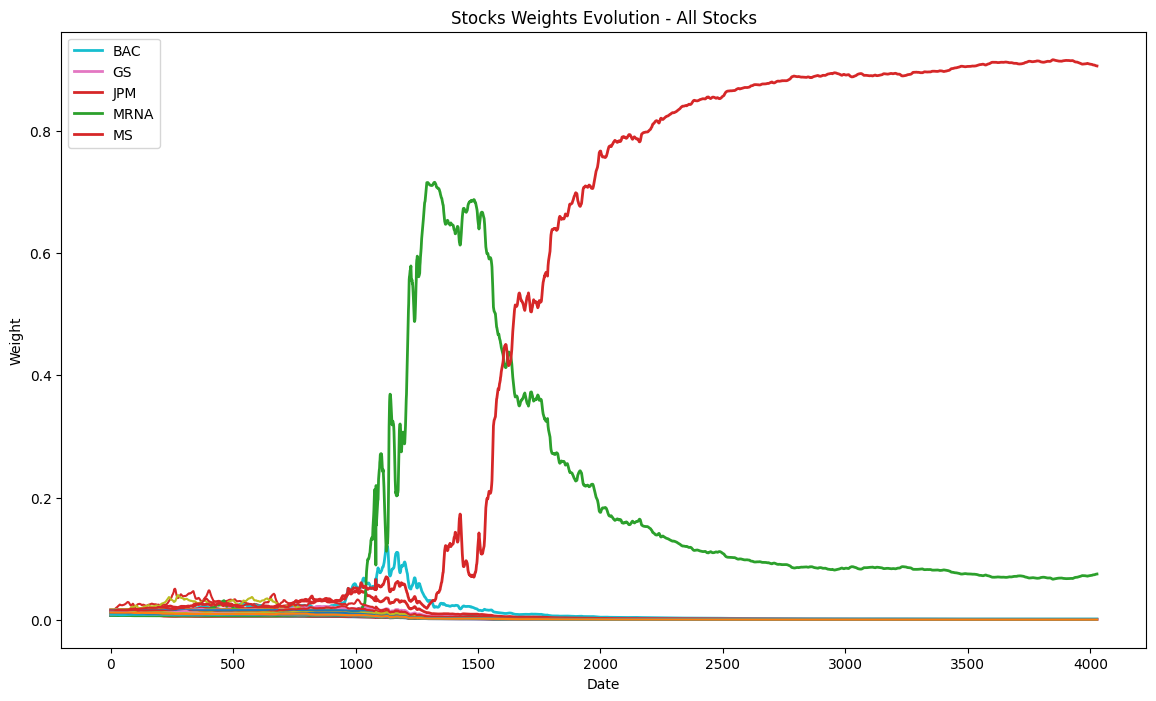

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (14, 8))

top_five_holdings = np.argsort(weights_log[-1])[-5:][::-1]

for i in range(weights_log.shape[1]):
    if i in top_five_holdings:
        ax.plot(weights_log[:, i], linewidth=2, label=returns.columns[i])
    else:
        ax.plot(weights_log[:, i])

ax.set_title("Stocks Weights Evolution - All Stocks")
ax.set_xlabel('Date')
ax.set_ylabel('Weight')
ax.legend()

## Meta Gradient Descent Portfolio Optimization

In [19]:
# Import the OnlinePortfolioOptimizer class from the previous code
class OnlinePortfolioOptimizer:
    def __init__(self,
                 n_assets,
                 initial_learning_rate=0.01,
                 decay_rate=0.995,
                 momentum=0.9,
                 window_size=252,
                 alphas=(1.0, 1.0, 1.0, 0.5, 0.2),
                 transaction_penalty_factor=0.1,
                 sparsity_factor=0.05):

        self.n_assets = n_assets
        self.initial_lr = initial_learning_rate
        self.current_lr = initial_learning_rate
        self.decay_rate = decay_rate
        self.momentum = momentum
        self.window_size = int(window_size) if window_size is not None else 252
        self.alphas = alphas
        self.transaction_penalty_factor = transaction_penalty_factor
        self.sparsity_factor = sparsity_factor

        # Store previous weights for transaction cost calculation
        self.previous_weights = None

        # Initialize weights equally
        self.weights = torch.ones(n_assets) / n_assets
        self.velocity = torch.zeros(n_assets)
        self.t = 0

    def _decay_learning_rate(self):
        self.current_lr = self.initial_lr * (self.decay_rate ** self.t)

    def _calculate_expected_returns_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        expected_returns = returns.mean()
        grad = expected_returns / 0.5
        return torch.tensor(grad.values, dtype=torch.float32)

    def _calculate_sortino_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()
        portfolio_returns = torch.matmul(torch.tensor(returns.values, dtype=torch.float32), self.weights)

        rf_daily = 0.02 / 252
        excess_returns = torch.tensor(returns.values, dtype=torch.float32) - rf_daily

        # Find indices where portfolio returns are negative
        negative_mask = portfolio_returns < 0
        negative_returns = excess_returns[negative_mask]

        if len(negative_returns) > 0:
            downside_std = torch.sqrt(torch.mean(torch.square(negative_returns)))
        else:
            downside_std = torch.tensor(1e-6)

        grad = (torch.mean(excess_returns, dim=0) / (3.0 * downside_std))
        return grad

    def _calculate_drawdown_gradient(self, prices_df):
        window_data = prices_df.iloc[-self.window_size:]
        returns = window_data.pct_change().dropna()

        # Convert returns to torch tensor
        returns_tensor = torch.tensor(returns.values, dtype=torch.float32)

        # Calculate cumulative returns for the portfolio
        portfolio_returns = torch.matmul(returns_tensor, self.weights)
        cumulative_returns = torch.cumprod(1 + portfolio_returns, dim=0)

        # Find the maximum drawdown point
        peak = torch.cummax(cumulative_returns, dim=0)[0]
        drawdown = cumulative_returns / peak - 1
        max_dd_idx = torch.argmin(drawdown)

        # Calculate gradient
        if max_dd_idx > 0:
            grad = -torch.mean(returns_tensor[:max_dd_idx+1], dim=0)
        else:
            grad = torch.zeros(self.n_assets)

        return grad

    def _project_onto_simplex(self, weights):
        if torch.sum(weights) <= 0:
            return torch.ones(self.n_assets) / self.n_assets

        sorted_weights, _ = torch.sort(weights, descending=True)
        cumulative_sum = torch.cumsum(sorted_weights, dim=0)

        k = 1
        for i in range(1, len(weights) + 1):
            v_k = (cumulative_sum[i-1] - 1) / i
            if i == len(weights) or sorted_weights[i] <= v_k:
                k = i
                break

        threshold = v_k
        return torch.maximum(weights - threshold, torch.zeros_like(weights))

    def step(self, prices_df, verbose=True):
        if len(prices_df) < self.window_size:
            if verbose:
                print(f"Insufficient data points ({len(prices_df)}/{self.window_size}). Returning current weights.")
            return self.weights

        self.t += 1
        prev_lr = self.current_lr
        self._decay_learning_rate()

        if verbose:
            print(f"\n===== Optimization Step {self.t} =====")
            print(f"Learning rate: {prev_lr:.6f} → {self.current_lr:.6f}")

            if self.previous_weights is not None:
                # Calculate portfolio sparsity metrics
                nonzero_positions = (self.weights > 0.001).sum().item()
                l1_norm = torch.sum(torch.abs(self.weights)).item()
                print(f"Current portfolio stats:")
                print(f"  Active positions (>0.1%): {nonzero_positions} / {self.n_assets}")
                print(f"  L1 norm: {l1_norm:.4f}")

            # Log current portfolio stats
            weights_list = self.weights.cpu().tolist()
            top_holdings = [(idx, w) for idx, w in sorted(
                enumerate(weights_list), key=lambda x: x[1], reverse=True) if w > 0.01]

            if top_holdings:
                print("Current top holdings (>1%):")
                for idx, weight in top_holdings[:5]:  # Show top 5
                    ticker = prices_df.columns[idx]
                    print(f"  {ticker}: {weight*100:.2f}%")

                print(f"Portfolio concentration (HHI): {(self.weights**2).sum().item()*10000:.2f}")

        try:
            # Calculate gradients
            er_grad = self._calculate_expected_returns_gradient(prices_df)
            sortino_grad = self._calculate_sortino_gradient(prices_df)
            dd_grad = self._calculate_drawdown_gradient(prices_df)

            if verbose:
                # Log gradient magnitudes for each component
                er_norm = torch.norm(er_grad).item()
                sortino_norm = torch.norm(sortino_grad).item()
                dd_norm = torch.norm(dd_grad).item()

                print("\nGradient components:")
                print(f"  Expected returns gradient magnitude: {er_norm:.4f}")
                print(f"  Sortino ratio gradient magnitude: {sortino_norm:.4f}")
                print(f"  Drawdown gradient magnitude: {dd_norm:.4f}")

                # Identify stocks with the largest gradients
                for grad_name, grad in [("Expected returns", er_grad),
                                       ("Sortino", sortino_grad),
                                       ("Drawdown", dd_grad)]:

                    top_idx = torch.argsort(grad, descending=True)[:3]
                    print(f"\n  Top 3 positive {grad_name} signals:")
                    for idx in top_idx:
                        # Convert PyTorch tensor index to Python int for DataFrame indexing
                        idx_int = idx.item()
                        ticker = prices_df.columns[idx_int]
                        print(f"    {ticker}: {grad[idx].item():.4f}")

            # Store current weights for transaction penalty calculation
            old_weights = self.weights.clone()

            # Calculate transaction cost penalty gradient (if we have previous weights)
            if self.previous_weights is not None:
                transaction_penalty_grad = -torch.sign(old_weights - self.previous_weights) * self.transaction_penalty_factor

                if verbose:
                    penalty_magnitude = torch.norm(transaction_penalty_grad).item()
                    print(f"\nTransaction penalty gradient magnitude: {penalty_magnitude:.4f}")
            else:
                transaction_penalty_grad = torch.zeros_like(old_weights)
                if verbose:
                    print("\nNo transaction penalty for first step (no previous weights)")

            # Calculate L1 sparsity gradient
            l1_sparsity_grad = -torch.sign(old_weights) * self.sparsity_factor

            if verbose:
                sparsity_magnitude = torch.norm(l1_sparsity_grad).item()
                print(f"L1 sparsity gradient magnitude: {sparsity_magnitude:.4f}")

            # Combine all gradients using alpha weights
            total_grad = (self.alphas[0] * er_grad +
                         self.alphas[1] * sortino_grad -
                         self.alphas[2] * dd_grad +
                         self.alphas[3] * transaction_penalty_grad +
                         self.alphas[4] * l1_sparsity_grad)

            # Update velocity and weights
            old_velocity = self.velocity.clone()
            self.velocity = self.momentum * old_velocity + self.current_lr * total_grad

            if verbose:
                print("\nMomentum update:")
                print(f"  Momentum factor: {self.momentum:.4f}")
                print(f"  Velocity change magnitude: {torch.norm(self.velocity - old_velocity).item():.4f}")

            new_weights = old_weights + self.velocity

            # Calculate transaction costs for reporting only (no hard constraint anymore)
            costs = torch.sum(torch.abs(new_weights - old_weights)) * 0.001

            if verbose:
                print(f"\nTransaction costs: {costs*100:.4f}%")

            # Store current weights as previous for next iteration
            self.previous_weights = old_weights.clone()

            # Project onto simplex
            self.weights = self._project_onto_simplex(new_weights)

            if verbose:
                # Log biggest weight changes
                weight_changes = self.weights - old_weights
                increase_idx = torch.argsort(weight_changes, descending=True)[:3]
                decrease_idx = torch.argsort(weight_changes)[:3]

                print("\nBiggest position increases:")
                for idx in increase_idx:
                    # Convert PyTorch tensor index to Python int
                    idx_int = idx.item()
                    ticker = prices_df.columns[idx_int]
                    old_pct = old_weights[idx].item() * 100
                    new_pct = self.weights[idx].item() * 100
                    print(f"  {ticker}: {old_pct:.2f}% → {new_pct:.2f}% (Δ{new_pct-old_pct:+.2f}%)")

                print("\nBiggest position decreases:")
                for idx in decrease_idx:
                    # Convert PyTorch tensor index to Python int
                    idx_int = idx.item()
                    ticker = prices_df.columns[idx_int]
                    old_pct = old_weights[idx].item() * 100
                    new_pct = self.weights[idx].item() * 100
                    print(f"  {ticker}: {old_pct:.2f}% → {new_pct:.2f}% (Δ{new_pct-old_pct:+.2f}%)")

        except Exception as e:
            print(f"Error in step: {e}")
            import traceback
            traceback.print_exc()
            # Return current weights if there's an error

        return self.weights

    def get_weights(self):
        return self.weights

In [6]:
def evaluate_hyperparams(prices_df, hyperparams, steps=30):
    optimizer = OnlinePortfolioOptimizer(
        n_assets=prices_df.shape[1],
        initial_learning_rate=hyperparams["initial_learning_rate"],
        decay_rate=hyperparams["decay_rate"],
        momentum=hyperparams["momentum"],
        window_size=hyperparams["window_size"],
    )
    weights = None
    for i in range(steps):
        sub_df = prices_df.iloc[:optimizer.window_size + i]
        weights = optimizer.step(sub_df, verbose=False)

    # Evaluate using cumulative return
    returns = prices_df.pct_change().dropna()
    portfolio_returns = (returns @ weights.numpy()).cumsum()
    return portfolio_returns.iloc[-1]

def evaluate_objective(prices_df, hyperparams, alphas=(1.0, 1.0, 1.0, 0.5, 0.2), steps=30):
    optimizer = OnlinePortfolioOptimizer(
        n_assets=prices_df.shape[1],
        initial_learning_rate=hyperparams["initial_learning_rate"],
        decay_rate=hyperparams["decay_rate"],
        momentum=hyperparams["momentum"],
        window_size=int(hyperparams["window_size"]),
        alphas=alphas,
        transaction_penalty_factor=0.1,
        sparsity_factor=0.05,
    )

    prev_weights = None
    total_score = 0

    for i in range(steps):
        sub_df = prices_df.iloc[:optimizer.window_size + i]
        weights = optimizer.step(sub_df, verbose=False)

        # --- Compute each component manually ---
        window_returns = sub_df.pct_change().dropna()
        portfolio_returns = window_returns @ weights.numpy()
        excess_returns = portfolio_returns - (0.02 / 252)

        # Expected Return
        er = np.mean(excess_returns)

        # Sortino Ratio
        downside = excess_returns[excess_returns < 0]
        sortino = er / (np.std(downside) + 1e-6)

        # Max Drawdown
        cumulative = (1 + portfolio_returns).cumprod()
        running_max = np.maximum.accumulate(cumulative)
        drawdown = cumulative / running_max - 1
        max_dd = np.min(drawdown)

        # Transaction Cost Penalty
        tc_penalty = 0
        if prev_weights is not None:
            tc_penalty = np.sum(np.abs(weights.numpy() - prev_weights.numpy())) * 0.001

        # Sparsity Penalty
        sparsity_penalty = np.sum(np.abs(weights.numpy()))

        prev_weights = weights.clone()

        # Combine using alphas
        score = (
            alphas[0] * er +
            alphas[1] * sortino -
            alphas[2] * abs(max_dd) -
            alphas[3] * tc_penalty -
            alphas[4] * sparsity_penalty
        )
        total_score += score

    return total_score / steps


def hyperparam_gradient_descent(prices_df, initial_params, lr=0.01, n_iter=10):
    params = initial_params.copy()
    keys = list(params.keys())
    history = []

    for iteration in range(n_iter):
        grads = {}
        # base_score = evaluate_hyperparams(prices_df, params)
        base_score = evaluate_objective(prices_df, params)

        # Log the current state
        record = {"iteration": iteration + 1, "score": base_score}
        record.update(params.copy())
        history.append(record)

        for key in keys:
            eps = 1e-3
            perturbed = params.copy()
            perturbed[key] += eps

            # Clip
            if "momentum" in key or "decay" in key:
                perturbed[key] = min(max(perturbed[key], 0), 1)
            if "window_size" in key:
                perturbed[key] = max(30, int(perturbed[key]))

            # score = evaluate_hyperparams(prices_df, perturbed)
            score = evaluate_objective(prices_df, perturbed)
            grads[key] = (score - base_score) / eps

        for key in keys:
            params[key] += lr * grads[key]

    return params, history

def plot_hyperparam_optimization(history):
    """
    history: List of dicts, where each dict contains:
      - 'iteration': int
      - 'score': float
      - each hyperparam: float
    """
    if not history:
        print("No optimization history to plot.")
        return

    keys = [k for k in history[0].keys() if k != 'iteration' and k != 'score']
    iterations = [h['iteration'] for h in history]
    scores = [h['score'] for h in history]

    fig, axs = plt.subplots(len(keys) + 1, 1, figsize=(8, 4 * (len(keys) + 1)))

    # Plot score
    axs[0].plot(iterations, scores, marker='o')
    axs[0].set_title("Performance Metric Over Iterations")
    axs[0].set_ylabel("Score (e.g., cumulative return)")
    axs[0].grid(True)

    # Plot each hyperparameter
    for i, key in enumerate(keys):
        values = [h[key] for h in history]
        axs[i+1].plot(iterations, values, marker='o')
        axs[i+1].set_title(f"{key} Over Iterations")
        axs[i+1].set_ylabel(key)
        axs[i+1].grid(True)

    plt.xlabel("Iteration")
    plt.tight_layout()
    plt.show()
